In [1]:
import torch 
import torchvision 
from torch import nn
from torchvision import transforms

import matplotlib.pyplot as plt

In [2]:
# import some custom functions (have already written and tested) 
import os 
import sys


parent_dir = os.path.abspath(os.path.join(os.getcwd(),os.pardir))
sys.path.append(parent_dir)

from  pytorch_deep_learning.going_modular.going_modular import data_setup, engine
from  pytorch_deep_learning import helper_functions

sys.path.remove(parent_dir)

In [3]:
# setup device agnostic code 
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [5]:
# download data 
from helper_functions import download_data, set_seeds, plot_loss_curves
image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                           destination="pizza_steak_sushi")
image_path

[INFO] data/pizza_steak_sushi directory exists, skipping download.


PosixPath('data/pizza_steak_sushi')

In [6]:
# setup the directory paths to train and test images 
train_dir = image_path/'train'
test_dir = image_path/'test'

In [10]:
# create data sets and data loaders 
IMG_SIZE = 224
manual_transform = transforms.Compose([transforms.Resize((IMG_SIZE,IMG_SIZE)),transforms.ToTensor()])

In [11]:
# turn images into dataloaders 
BATCH_SIZE = 32 
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir, test_dir=test_dir, 
                                                                               transform=manual_transform, batch_size = BATCH_SIZE)

In [13]:
# visualize an image 
image_batch, label_batch = next(iter(train_dataloader))
image, label = image_batch[0], label_batch[0]

(-0.5, 223.5, 223.5, -0.5)

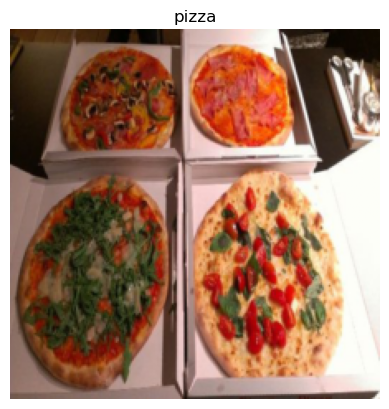

In [16]:
# plot test image
plt.imshow(image.permute(1,2,0))
plt.title(class_names[label])
plt.axis(False)

In [18]:
image.shape

torch.Size([3, 224, 224])

In [26]:
# creating image patches: size of patch = 16 
# N = [224*224]/[16*16] -> [14*14]
# input: [1,3,224,224] -> output: [1,768,14,14] 

patch_size = 16 

conv2d = nn.Conv2d(in_channels=3,out_channels=768,kernel_size=patch_size,stride=patch_size,padding=0)
image_out_of_conv = conv2d(image.unsqueeze(0))
image_out_of_conv.shape

torch.Size([1, 768, 14, 14])

In [27]:
# create flatten layer
flatten = nn.Flatten(start_dim=2,end_dim=3)
image_out_of_conv_flatten = flatten(image_out_of_conv)
image_out_of_conv_flatten.shape

torch.Size([1, 768, 196])

In [28]:
# patch embedding layer

class PatchEmbeddig(nn.Module):
    def __init__(self,in_channels:int=3,path_size:int=16,embedding_dim :int=768):
        super().__init__()
        # layer to convert image into patches 
        self.patcher = nn.Conv2d(in_channels=in_channels,out_channels=embedding_dim,
                                 kernel_size=patch_size,stride=path_size,padding=0)
        # flatten the patches 
        self.flatten = nn.Flatten(start_dim=2,end_dim=3)
        
    def forward(self,x):
        image_resolution = x.shape[-1]
        assert image_resolution % patch_size == 0,f"Input image size must be divisble by patch size, image shape: {image_resolution}, patch size: {patch_size}"
        
        x_patched = self.patcher(x)
        x_flattened = self.flatten(x_patched)
        return x_flattened.permute(0,2,1) # now the embedding on the last dim 

In [32]:
set_seeds()
patchify = PatchEmbeddig(in_channels=3,path_size=16,embedding_dim=768)

# pass a single image through 
print(f"input image shape: {image.unsqueeze(0).shape}")
patch_embedded_image = patchify(image.unsqueeze(0))
print(f"output patch embedding shape:{patch_embedded_image.shape}")

input image shape: torch.Size([1, 3, 224, 224])
output patch embedding shape:torch.Size([1, 196, 768])


In [34]:
# creating class token embedding [B,1,embedding_dim=768]

# 1. Get the batch size and embedding dimension 
batch_size = patch_embedded_image.shape[0]
embedding_dimension = patch_embedded_image.shape[-1]

# 2. Create class token (the last dim is same as for patch embedding dim)
class_token = nn.Parameter(torch.ones(batch_size,1,embedding_dimension,requires_grad=True))

torch.Size([1, 1, 768])

In [35]:
# 3. add the class embedding to patch embedding layer 
patch_embedded_image_with_class_embedding = torch.cat((class_token,patch_embedded_image),dim=1)
patch_embedded_image_with_class_embedding.shape

torch.Size([1, 197, 768])

In [36]:
# positional embedding : positional embeddings are added to patch embedding to retain positional info

number_of_positions = patch_embedded_image_with_class_embedding.shape[1]
embedding_dimension = patch_embedded_image_with_class_embedding.shape[2]

positional_embedding = nn.Parameter(torch.ones(1,number_of_positions,embedding_dimension,requires_grad=True))
positional_embedding.shape

torch.Size([1, 197, 768])

In [37]:
# patch and positional embedding 
patch_and_positional_embedding = patch_embedded_image_with_class_embedding + positional_embedding
patch_and_positional_embedding.shape

torch.Size([1, 197, 768])

In [38]:
# build the multihead attention layer (+ layer normalization)

class MultiheadSelfAttentionBlock(nn.Module):
    def __init__(self, embedding_dim:int=768,num_heads:int=12, attn_dropout:float=0):
        super().__init__()
        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim) # layer norm 
        self.multihead_attn = nn.MultiheadAttention(embed_dim=embedding_dim,num_heads=num_heads, # MSA layer 
                                                    dropout=attn_dropout,batch_first=True)
        
    def forward(self,x):
        x = self.layer_norm(x)
        atten_output,_ = self.multihead_attn(query=x,key=x,value=x,need_weights=False)
        return atten_output

In [39]:
multihead_self_attention_block = MultiheadSelfAttentionBlock(embedding_dim=768,num_heads=12)
patched_image_through_msa_block = multihead_self_attention_block(patch_and_positional_embedding)
patched_image_through_msa_block.shape

torch.Size([1, 197, 768])

In [40]:
# build MLP layer 
class MLPBlock(nn.Module):
    def __init__(self,embedding_dim:int=768,mlp_size:int=3072,dropout:float=0.1):
        super().__init__()
        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)
        self.mlp = nn.Sequential(nn.Linear(in_features=embedding_dim,out_features=mlp_size),
                                 nn.GELU(),
                                 nn.Dropout(p=dropout),
                                 nn.Linear(in_features=mlp_size,out_features=embedding_dim),
                                 nn.Dropout(p=dropout))
    def forward(self,x):
        x = self.layer_norm(x)
        x = self.mlp(x)
        return x 

In [41]:
# create MLP block and pass data through it 
mlp_block = MLPBlock(embedding_dim=768,mlp_size=3072,dropout=0.1)
patched_image_through_mlp_block = mlp_block(patched_image_through_msa_block)
patched_image_through_msa_block.shape

torch.Size([1, 197, 768])